### Introduction
After learning about several clustering methods, we are tasked with applying these techniques to the [Boston Marathon dataset](https://github.com/llimllib/bostonmarathon).  In this case, I have chosen data from the year 2013.  Specifically, we are asked to determine which clustering technique is best for the marathon results and include a writeup on what we have discovered.  

Something I didn't know about the Boston Marathon is that it includes wheelchair racers and hand cyclists.  This dataset only includes those who ran on their feet and wheelchair racers, but it would be interesting to see if any clustering techniques are able to distinguish between runners, wheelchair racers, and gender, giving a total of 4 clusters.

### 1 - Importing the Data


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, SpectralClustering
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn import metrics


In [2]:
df = pd.read_csv('boston_marathon_results.csv')

In [3]:
df.head()

,25k,age,name,division,10k,gender,half,official,bib,ctz,...,overall,pace,state,30k,5k,genderdiv,20k,35k,city,40k
0,49.87,28,"Cassidy, Josh R.",9,18.18,M,40.93,90.90,W1,NaN,...,9,3.47,ON,62.07,8.90,9,38.80,74.73,Toronto,85.55
1,77.27,30,"Korir, Wesley",5,30.90,M,64.90,132.50,1,NaN,...,5,5.07,NaN,92.97,15.90,5,61.52,108.78,Kenya,124.77
2,77.23,23,"Desisa, Lelisa",1,30.90,M,64.92,130.37,2,NaN,...,1,4.98,NaN,92.72,15.93,1,61.53,108.68,Ambo,123.78
3,50.50,32,"Fearnley, Kurt H.",5,18.73,M,42.00,88.43,W2,NaN,...,5,3.38,NaN,61.35,8.98,5,39.88,73.00,Hamilton,83.43
4,48.75,39,"Hokinoue, Kota",3,18.18,M,40.57,87.22,W3,NaN,...,3,3.33,NaN,59.92,8.92,3,38.55,71.68,Iizuka,81.88


In [4]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16164 entries, 0 to 16163
Data columns (total 21 columns):
25k          16164 non-null object
age          16164 non-null int64
name         16164 non-null object
division     16164 non-null int64
10k          16164 non-null object
gender       16164 non-null object
half         16164 non-null object
official     16164 non-null float64
bib          16164 non-null object
ctz          757 non-null object
country      16164 non-null object
overall      16164 non-null int64
pace         16164 non-null float64
state        14701 non-null object
30k          16164 non-null object
5k           16164 non-null object
genderdiv    16164 non-null int64
20k          16164 non-null object
35k          16164 non-null object
city         16163 non-null object
40k          16164 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 14.8 MB


In [5]:
df.describe()

,age,division,official,overall,pace,genderdiv
count,16164.000000,16164.000000,16164.000000,16164.000000,16164.000000,16164.000000
mean,41.638332,1100.967025,208.159470,8429.373422,7.947398,4351.684732
std,10.351311,942.114816,23.743608,5052.024116,0.905739,2772.398239
min,18.000000,1.000000,85.530000,1.000000,3.270000,1.000000
25%,34.000000,363.000000,191.727500,4061.750000,7.320000,2032.750000
50%,42.000000,842.000000,209.225000,8247.500000,7.980000,4113.500000
75%,49.000000,1560.000000,225.230000,12662.250000,8.600000,6316.000000
max,80.000000,3834.000000,284.230000,17598.000000,10.850000,10648.000000


#### 1.1 - Missing Data
There are 3 features with missing categories: ctz, state, and city.  The feature 'ctz' is the citizenship the runner holds.  Since 95% of the values are missing, I will remove this feature for this exercise.

In [6]:
df.isnull().sum()

25k              0
age              0
name             0
division         0
10k              0
gender           0
half             0
official         0
bib              0
ctz          15407
country          0
overall          0
pace             0
state         1463
30k              0
5k               0
genderdiv        0
20k              0
35k              0
city             1
40k              0
dtype: int64

In the states column, there are missing value because those races were run in a country outside of the United States.  In this case, I will impute 'other'.  

In [7]:
df[df['state'].isnull()]['country'].unique()

array(['KEN', 'ETH', 'AUS', 'JPN', 'RSA', 'POL', 'SUI', 'ESP', 'FRA',
       'ITA', 'ECU', 'RUS', 'MEX', 'BER', 'GBR', 'DEN', 'NED', 'CRC',
       'ISL', 'IRL', 'GER', 'AUT', 'GRE', 'GUA', 'DOM', 'UKR', 'SWE',
       'NOR', 'SVK', 'BAH', 'BRA', 'HKG', 'KOR', 'VEN', 'CZE', 'HUN',
       'SLO', 'COL', 'PER', 'SIN', 'CHI', 'FIN', 'CHN', 'BEL', 'ARG',
       'UAE', 'URU', 'NZL', 'ISR', 'PAN', 'TWN', 'LTU', 'IND', 'POR',
       'MAS', 'CAY', 'EST', 'TRI', 'ESA', 'PHI', 'VGB', 'ARU', 'QAT',
       'TCA', 'BOL', 'TUR'], dtype=object)

In [8]:
df['state'].fillna('Other', inplace = True)

Lastly, there is the matter of the missing city.  This particular race was ran in Argentina.  Most of the races in Argentina were run in Buenos Aires, so I will fill the missing city with Buenos Aires.  I did try to search for the city, but failed to find the information.

In [9]:
df[df['city'].isnull()]['country']

10138    ARG
Name: country, dtype: object

In [10]:
df[df['country']=='ARG']['city'].value_counts()

Buenos Aires                       4
Mendoza                            2
Rojas                              1
Bahia Blanca                       1
Salta                              1
Mar Del Plata                      1
La Plata                           1
Ciudad Autonoma De Buenos Aires    1
Name: city, dtype: int64

In [11]:
df['city'].fillna('Buenos Aires', inplace = True)

### 2 - Data Cleaning

#### 2.1 - Creating Ground Truths
I know that when clustering, we don't always have ground truths.  However, I can create one for easy comparison between clusters and models.  In this case, I will have 4 categories:  M, F, WM, and WF, which stands for male, female, wheelchair male, and wheelchair female respectively.  

In [12]:
def get_ground_truth(gender, bib):
    if bib[0] == 'W':
        return 'W' + gender
    else:
        return gender
df['racertype'] = df.apply(lambda x: get_ground_truth(x['gender'], x['bib']), axis = 1)

The dataset is pretty unbalanced now, with only ~50 racers in wheelchairs finishing the race vs ~16k runners on foot.  This could make it difficult to distinguish clusters.  If anything, the official times (and splits) are a big separator between those in wheelchairs and non wheelchair racers.  Below in the left chart, we see that the mean official times between wheelchair and non wheelchair racers differ by about 80 minutes, with wheelchair racers averaging ~120 minutes and non wheelchair racers somewhere between 200-220 minutes, depending on gender.  On the right chart is a plot of official times vs age.  Here we can see that there is a giant cluster for male runners, and inside is a subset of clusters for female runners.  The wheelchair racers are more spread out but are clearly separate from the runners.  They run into a similar problem of the genders blending together though.

In [13]:
df['racertype'].value_counts()

M     9637
F     6475
WM      43
WF       9
Name: racertype, dtype: int64

C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


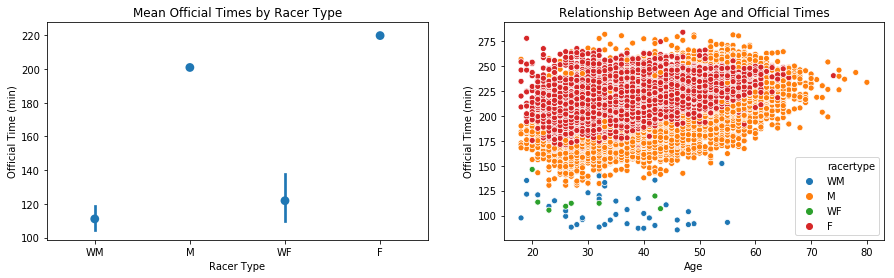

In [14]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize = (15, 4))
sns.pointplot(x = 'racertype', y = 'official', data = df, linestyles = '', ax = axis1)
sns.scatterplot(x = 'age', y = 'official', hue = 'racertype', data = df, ax = axis2)

axis1.set_title('Mean Official Times by Racer Type')
axis1.set_ylabel('Official Time (min)')
axis1.set_xlabel('Racer Type')

axis2.set_title('Relationship Between Age and Official Times')
axis2.set_ylabel('Official Time (min)')
axis2.set_xlabel('Age')

In [15]:
df.drop('gender', axis = 1, inplace = True)

#### 2.2 - Fixing Hidden Missing Values
I was wondering why the splits (i.e. 25k, 10k, etc) are objects instead of floats.  Turns out if there are missing values, they are labeled as '-'.  These values will be imputed by assuming the runner will have a steady pace over the whole marathon.  

In [16]:
float_lst = ['25k', '10k', 'half', '30k', '5k', '20k', '35k', '40k']

In [17]:
marathon_distance = 42.19506847 # in km
splits_dict = {'25k': 25/marathon_distance, '10k': 10/marathon_distance, 'half': 0.5, 
               '30k': 30/marathon_distance, '5k': 5/marathon_distance, '20k': 20/marathon_distance,
               '35k': 35/marathon_distance, '40k': 40/marathon_distance}

In [18]:
def get_distance(cols):
    for i in range(len(float_lst)):
        if cols[i]=='-':
            return splits_dict[float_lst[i]] * cols[8]

In [19]:
for col in float_lst:
    condition = df[col]=='-'
    df.loc[condition, [col]] = df.loc[condition].apply(lambda x: get_distance(x[float_lst + ['official']].values), axis = 1)
    df[col] = pd.to_numeric(df[col], downcast = 'float')

### 3 - Applying Cluster Techniques
Here, I would like to use 2 clustering techniques:  kmeans and mean shift.  I would have liked to apply spectral clustering to, but my computer cannot handle it.  

#### 3.1 - Prepping the Data
Before applying the clustering techniques, I need to prep the data.  There are two things I need to do to prep the data:  1)  remove extraneous features, and 2) normalize the data.  The features I think are unneeded are names and locations (ctz, country, state, city).  I will also remove genderdiv because I'm afraid of target leakage.  

In [20]:
df.drop(['name', 'genderdiv', 'ctz', 'country', 'state', 'city'], axis = 1, inplace = True)

I suspect bib numbers are important, since most of the racers in wheelchairs have numbers going up to the 100, maybe 150 at most.  I am concerned however that there is a W in the bib number.  There are two choices to deal with the W, either remove it or encode it.  For now, I will try removing it to preserve the actual number.

In [21]:
def remove_bib_letters(col):
    if col[0].isnumeric():
        return col
    else:
        return col[1:]
    
df['bib'] = df['bib'].apply(lambda x: remove_bib_letters(x))

Lastly, I would like to normalize the data.

In [22]:
X = df.drop('racertype', axis = 1)
y = df['racertype']

In [23]:
X_norm = normalize(X)

In addition, I'd like to apply PCA to the data.  For a first try, I'd like to reduce the data down to 4 features.  

In [24]:
X_pca = PCA(4).fit_transform(X_norm)

#### 3.2 - K Means Clustering
Based on the crosstabs, it seems that the pca transformed data performs better than the non-pca data, but the main difference is identifying more female runners.  Male runners and those in wheelchairs do not change much.  In fact, it seems like both normalized and pca transformed data group the wheelchair racers as one group.

In [25]:
y_pred_kmeans = KMeans(n_clusters = 4, random_state=42).fit_predict(X_norm)

In [26]:
print(pd.crosstab(y_pred_kmeans, y))

racertype     F     M  WF  WM
row_0                        
0          2336  3097   0   0
1           200  2414   0   0
2          3939  3878   0   0
3             0   248   9  43


In [27]:
y_pred_PCAkmeans = KMeans(n_clusters = 4, random_state=42).fit_predict(X_pca)

In [28]:
print(pd.crosstab(y_pred_PCAkmeans, y))

racertype     F     M  WF  WM
row_0                        
0          3950  3880   0   0
1           202  2419   0   0
2          2323  3092   0   0
3             0   246   9  43


The adjusted rand index (ARI) compares how the pairs of data points are related to the ground truth in the new solution.  Values range from 0 to 1, where 1 means the pairs are in complete agreement and 0 indicates perfect randomness.  For both the normalized and pca transformed data, the ARI are pretty close to randomness, at around 0.018.  

In [29]:
print('ARI for normalized data: {}'.format(metrics.adjusted_rand_score(y, y_pred_kmeans)))
print('ARI for pca transformed data: {}'.format(metrics.adjusted_rand_score(y, y_pred_PCAkmeans)))

ARI for normalized data: 0.018256560786382745
ARI for pca transformed data: 0.01844315660845497


A possible explanation is that I'm using the wrong number of clusters.  Below, I've plotted the ARI against the number of clusters for the normalized and pca transformed data.  It seems that the best ARI comes from 6 clusters for both transformed sets of data.

In [30]:
kmeans_norm_ari_lst = []
kmeans_pca_ari_lst = []

for k in range(2, 11):
    tmp_pca = KMeans(n_clusters = k, random_state=42).fit_predict(X_pca)
    kmeans_pca_ari_lst.append(metrics.adjusted_rand_score(y, tmp_pca))
    tmp_norm = KMeans(n_clusters = k, random_state=42).fit_predict(X_norm)
    kmeans_norm_ari_lst.append(metrics.adjusted_rand_score(y, tmp_norm))

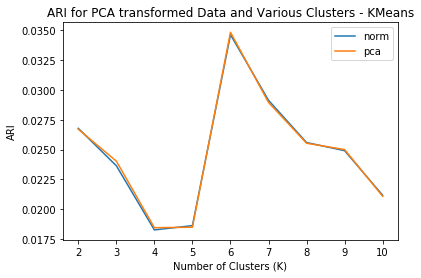

In [31]:
plt.plot(range(2,11), kmeans_norm_ari_lst)
plt.plot(range(2,11), kmeans_pca_ari_lst)
plt.title('ARI for PCA transformed Data and Various Clusters - KMeans')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('ARI')
plt.legend(['norm', 'pca'])

#### 3.3 - Mean Shift
With mean shift clustering, the algorithm predicts the number of clusters.  With some adjusting to get the best ARI score, the predicted number of clusters for both normalized and pca transformed data was 4, and ARI ~0.026, which is not as good as k-means.  On the positive side, mean shift seems to be able to distinguish between the genders in the wheelchair racers.

In [32]:
bandwidth_norm = estimate_bandwidth(X_norm, quantile=0.35, n_samples=1000)
ms_norm = MeanShift(bandwidth=bandwidth_norm, bin_seeding=True)
ms_norm.fit(X_norm)
labels_norm = ms_norm.labels_
cluster_centers_norm = ms_norm.cluster_centers_
n_clusters_norm = len(np.unique(labels_norm))

print("Number of estimated clusters: {}".format(n_clusters_norm))

Number of estimated clusters: 4


In [36]:
print(pd.crosstab(labels_norm, y))

racertype     F     M  WF  WM
row_0                        
0          6468  6416   0   0
1             7  2994   0   0
2             0    51   0  43
3             0   176   9   0


In [33]:
bandwidth_pca = estimate_bandwidth(X_pca, quantile=0.35, n_samples=1000)
ms_pca = MeanShift(bandwidth=bandwidth_pca, bin_seeding=True)
ms_pca.fit(X_pca)
labels_pca = ms_pca.labels_
cluster_centers_pca = ms_pca.cluster_centers_
n_clusters_pca = len(np.unique(labels_pca))

print("Number of estimated clusters: {}".format(n_clusters_pca))

Number of estimated clusters: 4


In [35]:
print(pd.crosstab(labels_pca, y))

racertype     F     M  WF  WM
row_0                        
0          6468  6419   0   0
1             7  2999   0   0
2             0    51   0  43
3             0   168   9   0


In [34]:
print('ARI for normalized data: {}'.format(metrics.adjusted_rand_score(y, labels_norm)))
print('ARI for pca transformed data: {}'.format(metrics.adjusted_rand_score(y, labels_pca)))

ARI for normalized data: 0.026087732574383533
ARI for pca transformed data: 0.02627153014323408


### 4 - Conclusions
In this notebook, I tried to use clustering techniques to separate racers into four categories: male runners, female runners, male wheelchair racers, and female wheelchair racers.  Using k-means clustering, 6 was the optimal number of clusters for both normalized and pca transformed data, with an ARI of ~0.034.  With mean shift clustering, 4 was the optimal number of clusters, with an ARI of ~0.026.  From the crosstab information, it appears that both k-means and mean shift had a very difficult time distinguishing between male and female racers.  However, mean shift clustering was able to distinguish between genders for the wheelchair racers.  